```{index} single: application; Traveling Salesman Problem
```
```{index} gurobi
```

# Extra material: Traveling Salesman Problem


## Introduction
This notebook can be seen as an addition to both Chapter 3 (since it concerns mixed integer models, and analyses differences in strength) and to Chapter 4 (since it addresses a network optimization problem).

In this notebook we illustrate several things:
 1. That different **correct** models for the same (mixed) integer optimization problem may require substantially different effort to optimize.
 1. That different models can be combined, and why that may become interesting.
 1. That very large models can be specified 'on a need basis' by adding only the constraints that are needed for a specific instance.
 1. That exploiting knowledge about the instance (e.g. symmetry of the cost function) may dramatically reduce optimization effort.

First, we will deal with how to even formulate this problem, to which there are multiple answers.
Next, we shall solve each of the equivalent formulations with a solver and compare the solutions/solution times.
Note that an important formulation requires an exponential number of constraints, rendering it impractical to explicitly implement.
In the end, we will delve on how classic optimization techniques can be used to attack this problem in a way that is scalable.

This notebook focuses on the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_Salesman_problem) which may be the most studied (combinatorial) optimization problem.

A wonderful [source](https://www.math.uwaterloo.ca/tsp/) you may like to visit is maintained by [Prof. Bill Cook](https://www.math.uwaterloo.ca/~bico/).
You may consider reading this enlightening and exciting [book on the pursuit](https://press.princeton.edu/books/paperback/9780691163529/in-pursuit-of-the-traveling-salesman).

The main challenge when modelling the TSP is the _connectivity_ of the solution.

The [Wikipedia page](https://en.wikipedia.org/wiki/Travelling_Salesman_problem) lists two well-known models, the [Miller–Tucker–Zemlin](https://en.wikipedia.org/wiki/Travelling_Salesman_problem#Miller%E2%80%93Tucker%E2%80%93Zemlin_formulation[21]) and the [Dantzig–Fulkerson–Johnson](https://en.wikipedia.org/wiki/Travelling_Salesman_problem#Dantzig%E2%80%93Fulkerson%E2%80%93Johnson_formulation).

These are not the only TSP models, see [this](https://co-enzyme.fr/blog/spanning-tree-flow-based-formulations-for-the-asymmetric-traveling-Salesman-problem-tsp/) or [this](https://dm872.github.io/assets/dm872-TSP_Formulations.pdf) overviews.
A thorough [comparison](https://www.sciencedirect.com/science/article/pii/S2192437620600115) is also available.

Besides the practical computation difficulties, different formulations also have different merits as basis to model different business requirements.
A good example is this [very rich routing problem](https://onlinelibrary.wiley.com/doi/full/10.1002/net.21962) for which the computational impact of different model choices for the TSP parts of it has also been [studied](https://www.ubvu.vu.nl/scripties/getpdf.cfm?facid=27&id=21392).

As said, we focus on the [MTZ](https://en.wikipedia.org/wiki/Travelling_Salesman_problem#Miller%E2%80%93Tucker%E2%80%93Zemlin_formulation[21]) and the [DFJ](https://en.wikipedia.org/wiki/Travelling_Salesman_problem#Dantzig%E2%80%93Fulkerson%E2%80%93Johnson_formulation) models.

A first inspection to these models may invite you to choose the former and abandon any consideration of the latter, on the grounds of compactness: the [MTZ](https://en.wikipedia.org/wiki/Travelling_Salesman_problem#Miller%E2%80%93Tucker%E2%80%93Zemlin_formulation[21]) model consists of a polynomial number of variables and constraints, while the [DFJ](https://en.wikipedia.org/wiki/Travelling_Salesman_problem#Dantzig%E2%80%93Fulkerson%E2%80%93Johnson_formulation) model requires an exponential number of constraints.

In the case of the TSP, as this notebook shows, the strength of models is of paramount importance when we need to actually solve the problem.

In the end, compactness may ***not*** be all what matters!

### Preamble

Let us start importing the modules that we will need.

In [1]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
    %pip install gurobipy >/dev/null 2>/dev/null

In [2]:
import os, os.path, string, re, requests, numpy as np, matplotlib.pyplot as plt, itertools as it, pandas as pd, pyomo.environ as pyo
from time import perf_counter as pc
from tqdm.notebook import tqdm
from datetime import timedelta
from scipy.spatial import distance_matrix as euclidean

### Solvers and utilities

We will illustrate the differences between free and commercial solvers, and also the advantages of having the ability of modifying a model while solving with a persistent solver.

In [3]:
free_solver = "appsi_highs"
persistent_solver = "gurobi_persistent"

SOLVER = pyo.SolverFactory(free_solver)
PERSISTENT_SOLVER = pyo.SolverFactory(persistent_solver)

assert SOLVER.available(), f"Solver {solver} is not available."
assert PERSISTENT_SOLVER.available(), f"Solver {persistent_solver} is not available."

A transformation to obtain the linear relaxation of a given model.

In [4]:
linear_relaxation = pyo.TransformationFactory("core.relax_integer_vars")

A simple function to display an elapsed number of seconds as a digital clock.

In [5]:
display_seconds = lambda sec: str(timedelta(seconds=sec))[:-3]

### Data format

Since the TSP is very well-known and widely studied, there exists a [de-facto standard](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf) for the data format of its instances.

This is important due to the richness of widely studied benchmark instances.
Later down this notebook we will read such instances from the internet, we start generating random instances of convenient sizes and introduce some convenience functions to deal with their representation in `python` data structures.

The most important part of the data is for now the `NODE_COORD_SECTION` which we model as a list of triplets: `(index,x,y)`.

We limit us to the rounded integer values of the `EUC_2D` option for `EDGE_WEIGHT_TYPE` as described in [TSPLIB95](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf) for the lengths of the route segments.

Later we will read instances in that format from the internet.
Now we generate instances of convenient sizes.

In [6]:
def generate_tsp(n: int = 10, seed: int = 2023) -> dict[str, any]:
    """
    Generate a Traveling Salesman Problem (TSP) instance.

    Args:
        n (int, optional): Number of nodes. Defaults to 10.
        seed (int, optional): Seed for random number generation. Defaults to 2023.

    Returns:
        dict[str, Any]: A dictionary representing the TSP instance.
    """
    np.random.seed(seed)
    instance = dict()
    instance["NAME"] = f"n={n} seed={seed}"
    instance["NODE_COORD_SECTION"] = [
        (i + 1, np.random.randint(100), np.random.randint(100)) for i in range(n)
    ]
    return instance

### Functions to handle instances and solutions

When we read (or generate instances) we create `python` data structures that we manipulate with the functions below.

In [7]:
def get_rounded_euclidean_distances(instance: dict[str, any]) -> np.ndarray:
    """
    Calculate the cost matrix for TSP instance.

    Args:
        instance: The TSP instance.

    Returns:
        The cost matrix.

    """
    XY: np.ndarray = np.asmatrix([(x, y) for _, x, y in instance["NODE_COORD_SECTION"]])
    return np.round(euclidean(XY, XY), 0).astype(int)


def get_route_cost(route: list[int], C: np.ndarray) -> int:
    """
    Calculate the cost of a given route.

    Args:
        route: The route as a list of node indices.
        C: The cost matrix.

    Returns:
        The total cost of the route.

    """
    departure: list[int] = route[:-1]
    arrival: list[int] = route[1:]
    return sum(C[departure, arrival])


def get_indices_and_reverse_lookup(
    instance: dict[str, any]
) -> tuple[list[int], dict[int, int]]:
    """
    Get the node indices and reverse lookup dictionary for TSP instance.

    Args:
        instance: The TSP instance.

    Returns:
        A tuple containing the list of node indices and the reverse lookup dictionary.

    """
    I: list[int] = [i for i, *_ in instance["NODE_COORD_SECTION"]]
    R: dict[int, int] = {i: idx for idx, i in enumerate(I)}
    return I, R


def get_coordinates(instance: dict[str, any]) -> tuple[np.ndarray, np.ndarray]:
    """
    Get the X and Y coordinates of the nodes in the TSP instance.

    Args:
        instance: The TSP instance.

    Returns:
        A tuple containing the X and Y coordinates as NumPy arrays.

    """
    XY: list[tuple[int, int]] = [(x, y) for _, x, y in instance["NODE_COORD_SECTION"]]
    X, Y = zip(*XY)
    return np.array(X), np.array(Y)


def show_tsp(
    instance: dict[str, any],
    sol: list[int] = [],
    node_labels: bool = False,
    how: str = "",
    get_cost_matrix: callable = get_rounded_euclidean_distances,
) -> None:
    """
    Visualize the TSP instance and the solution.

    Args:
        instance: The TSP instance.
        sol: The solution as a list of node indices (optional).
        node_labels: Whether to display node labels (default: False).
        how: Additional information or description of the visualization (default: '').
        get_cost_matrix: Function to generate the cost matrix (default get_rounded_euclidean_distances).

    Returns:
        None

    """
    I, R = get_indices_and_reverse_lookup(instance)
    X, Y = get_coordinates(instance)

    S: list[int] = [R[s] for s in sol]

    markersize: int = 15 if node_labels else 5

    plt.plot(X, Y, "ro", markersize=markersize)
    if len(sol) > 0:
        plt.plot(X[S[0]], Y[S[0]], "yo", markersize=markersize)

    plt.plot(X[S], Y[S], "g-")

    if node_labels:
        for i, x, y in zip(I, X, Y):
            plt.annotate(
                f"{i}", (x, y), ha="center", va="center", color="white", fontsize=10
            )
        if len(sol) > 0:
            plt.annotate(
                f"{sol[0]}",
                (X[S[0]], Y[S[0]]),
                ha="center",
                va="center",
                color="r",
                fontsize=10,
            )

    plt.gca().set_xlabel("x")
    plt.gca().set_ylabel("y")

    C = get_cost_matrix(instance)
    plt.title(f"{instance['NAME']} {f'cost={get_route_cost(S, C)}' if S else ''} {how}")

    plt.axis("equal")

    plt.show()

## First impressions

We generate a first instance of small size to start playing with.

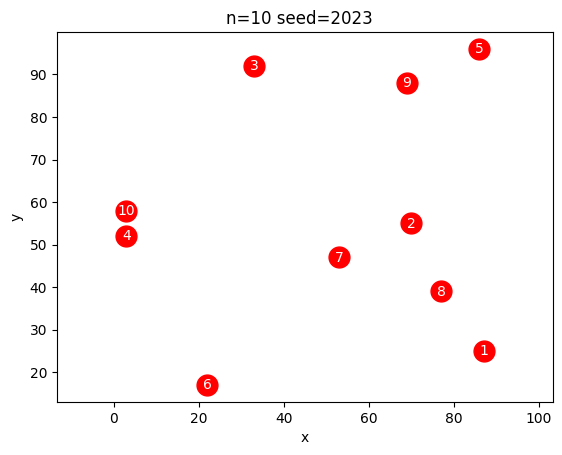

In [75]:
instance = generate_tsp(10)
show_tsp(instance, node_labels=True)

Just to show that the node labels may be very generic, we replace the numerical (1-based) indices by letters.

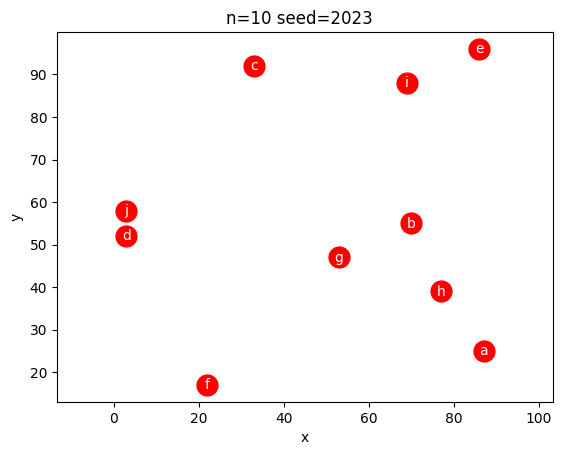

In [76]:
abc = list(string.ascii_lowercase)
instance["NODE_COORD_SECTION"] = [
    (i, x, y) for (i, (_, x, y)) in zip(abc, instance["NODE_COORD_SECTION"])
]
show_tsp(instance, node_labels=True)

## The models

Most of the models consider the decision variables:
$$
   x_{ij} = \left\{
     \begin{array}{lr}
       1 & \text{if node } j \text{ follows node } i \\
       0 & \text{otherwise}                          \\
     \end{array}
   \right.
$$
Later we will see how to reduce these number of variables to (less than) half in case of symmetric distances.

All models aim at minimizing the total distance traveled: $\sum_{i,j \in N} c_{ij}x_{ij}$.

The models share a core: they model the degree of the nodes and the number of node pairs chosen in the solution.
In the sequel, we refer to a chosen pair $(i,j)$ of nodes as an _arc_, which we may also call an _edge_ in case the distances are symmetric.
Pair (or arc) $(i,j)$ being chosen means that node $j$ follows node $i$ in the solutions, i.e. $x_{ij} = 1$.

Models based on arcs (i.e. listing all pairs $(i,j)$ of potential choices) share a **bipartite matching** or **linear assignment** core:
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}              & =    & 1     & \forall j \in N                       \\
        & \sum_{j \in N} x_{ij}              & =    & 1     & \forall i \in N                       \\
        & x_{ij} \in \{0,1\}                 &      &       & \forall i, j \in N
\end{array}
$$
As we learnt from Chapter 4, imposing the integrality (binary nature in this case) of the decision variables on the core model above is redundant, as it is natural integral by nature of its constraint matrix being [TUM](https://en.wikipedia.org/wiki/Unimodular_matrix#Total_unimodularity).

Since this property vanishes as soon as we complement the model in any known way (albeit some [published work](https://arxiv.org/pdf/cs/0609005) erroneously saying otherwise, see also entry 17 of this wonderful [legacy page](https://www.win.tue.nl/~wscor/woeginger/P-versus-NP.htm)) to reach a valid TSP model, we state the variables $x_{ij}$ variables as binary.

The core model forces the degree of each node to be 2 (one arc entering the node and one leaving it) and also force $n$ arcs to be used (that this is implied by the model above can be easily seen by adding any of the two groups of constraints).

Models vary in the way the way the enforce connectivity, as the core part fails in doing that. In fact, $x_{ii} = 1$ for all $i$ is feasible, but the TSP clearly leaves all vertices.

An immediate improvement to the core model is just to fix the `self-loops` to 0, i.e. $x_{ii} = 0$, but that is not enough as pairwise loops $x_{ij} = x_{ji} = 1$ become the next culprit.

An inductive reasoning on how to forbid all this _sub-tours_ leads to the well-known [**Dantzig, Fulkerson and Johnson**](https://en.wikipedia.org/wiki/Travelling_Salesman_problem#Dantzig%E2%80%93Fulkerson%E2%80%93Johnson_formulation) model
and formulates the TSP as:
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}   & =    & 1     & \forall j \in N                       \\
        & \sum_{j \in N} x_{ij}   & =    & 1     & \forall i \in N                       \\
        & \sum_{i,j \in S} x_{ij} & \leq & |S|-1 & \forall \emptyset \subset S \subset N \\
        & x_{ij} \in \{0,1\}      &      &       & \forall i, j \in N                    \\
\end{array}
$$
The model above prohibits the choice of enough arcs on each subset of nodes to sub-tour on those nodes.

An equivalent version of the same seems to be more popular, enforcing each subset of nodes to be connected to its complement.
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}              & =    & 1     & \forall j \in N                       \\
        & \sum_{j \in N} x_{ij}              & =    & 1     & \forall i \in N                       \\
        & \sum_{i \in S, j \not\in S} x_{ij} & \geq & 1     & \forall \emptyset \subset S \subset N \\
        & x_{ij} \in \{0,1\}                 &      &       & \forall i, j \in N                    \\
\end{array}
$$

Since this model requires an exponential number of (so-called sub-tour elimination) constraints we may prefer to start with a more compact model.

Fortunately, a [compact](https://en.wikipedia.org/wiki/Travelling_Salesman_problem#Miller-Tucker-Zemlin_formulation) model exists.
This ingenious model, devised by C. E. Miller, Alfred E. Tucker and R. A. Zemlin in 1960 adds _sequence_ variables $u_i$ and replace the connectivity (also known as subtour elimination) constraints which are in a exponential number by circa $n^2$ sequence constraints.

$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij} & =    & 1    & \forall j \in N                              \\
        & \sum_{j \in N} x_{ij} & =    & 1    & \forall i \in N                              \\
        & x_{ij} \in \{0,1\}    &      &      & \forall i, j \in N                           \\
        & u_i - u_j + nx_{ij}   & \leq & n-1  & \forall i,j \in N : 2 \leq i \not = j \leq n \\
        & u_i \in [0,n-2]       &      &      & \forall i \in N                              \\
\end{array}
$$

In fact, this model has been strengthened by several authors, see [this paper](https://www.sciencedirect.com/science/article/pii/S0166218X00003139).

The first improvement is as below:
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}   & =    & 1    & \forall j \in N                              \\
        & \sum_{j \in N} x_{ij}   & =    & 1    & \forall i \in N                              \\
        & x_{ij} \in \{0,1\}      &      &      & \forall i, j \in N                           \\
        & u_i - u_j + (n-1)x_{ij} & \leq & n-2  & \forall i,j \in N : 2 \leq i \not = j \leq n \\
        & u_i \in [0,n-2]         &      &      & \forall i \in N                              \\
\end{array}
$$

The best known as below:
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}                 & =    & 1    & \forall j \in N                              \\
        & \sum_{j \in N} x_{ij}                 & =    & 1    & \forall i \in N                              \\
        & x_{ij} \in \{0,1\}                    &      &      & \forall i, j \in N                           \\
        & u_i - u_j + (n-1)x_{ij} + (n-3)x_{ji} & \leq & n-2  & \forall i,j \in N : 2 \leq i \not = j \leq n \\
        & u_i \in [0,n-2]                       &      &      & \forall i \in N                              \\
\end{array}
$$
These versions of the MTZ model are equivalent in how they model connectivity, but have increasingly tighter linear relaxations.

Below we will consider three MTZ models: the basic one, the one improved by [Desrochers and Laporte](https://www.sciencedirect.com/science/article/pii/0167637791900832) and the best one so far by [Gouveia and Pires](https://www.sciencedirect.com/science/article/pii/S0166218X00003139).

### Building blocks for TSP models

As the good programmers that we all are, we will strive for modularity and reuse.
We will not regret!

In [10]:
def LAP(
    instance: dict[str, any],
    get_cost_matrix: callable = get_rounded_euclidean_distances,
) -> pyo.ConcreteModel:
    """
    Solve the Linear Assignment Problem (LAP) for a given instance.

    Args:
        instance: The LAP instance.
        get_cost_matrix: Function to generate the cost matrix (default get_rounded_euclidean_distances).

    Returns:
        The pyo.ConcreteModel representing the LAP problem.

    """
    I, R = get_indices_and_reverse_lookup(instance)
    C = get_cost_matrix(instance)

    m = pyo.ConcreteModel("LAP")

    m.n = pyo.Param(initialize=len(C), mutable=False)

    m.I = pyo.Set(initialize=I)
    m.IJ = m.I * m.I
    m.c = pyo.Param(m.IJ, initialize=lambda m, i, j: C[R[i], R[j]], mutable=False)
    m.x = pyo.Var(m.IJ, domain=pyo.Binary)

    @m.Objective(sense=pyo.minimize)
    def Cost(m: pyo.ConcreteModel) -> pyo.Expression:
        return pyo.quicksum(m.c[i, j] * m.x[i, j] for i, j in m.IJ)

    @m.Constraint(m.I)
    def DepartFromEach(m: pyo.ConcreteModel, i: m.I) -> pyo.Constraint:
        return pyo.quicksum(m.x[i, j] for j in m.I) == 1

    @m.Constraint(m.I)
    def ArriveAtEach(m: pyo.ConcreteModel, i: m.I) -> pyo.Constraint:
        return pyo.quicksum(m.x[j, i] for j in m.I) == 1

    return m

Note that the code below is a bit tricky: the functions **do** modify the model that they take as argument.
The fact that they return the model could lead into believing that not to be the case, but it is.
This construction has the convenience of allowing cascading (composing) function calls.

In [11]:
def ForbidDiagonal(m: pyo.ConcreteModel) -> pyo.ConcreteModel:
    """
    Add constraints to forbid diagonal elements in the LAP problem.

    Args:
        m: The pyomo.ConcreteModel representing the LAP problem.

    Returns:
        The modified pyomo.ConcreteModel.

    """

    @m.Constraint(m.I)
    def ForbidStaying(m: pyo.ConcreteModel, i: m.I) -> pyo.Constraint:
        return m.x[i, i] == 0

    return m

In [12]:
def PrepareMTZ(m: pyo.ConcreteModel) -> pyo.ConcreteModel:
    """
    Prepare the Miller-Tucker-Zemlin (MTZ) formulation for the TSP given a LAP model.

    Args:
        m: The pyomo.ConcreteModel representing the LAP model.

    Returns:
        The modified pyomo.ConcreteModel.

    """
    skip_first = list(m.I)[1:]
    m.I1 = pyo.Set(initialize=skip_first)
    m.IJ1 = pyo.Set(dimen=2, initialize=it.permutations(skip_first, 2))

    m.u = pyo.Var(m.I1, bounds=(0, m.n - 2))

    return m

In [13]:
def OriginalMTZ(m: pyo.ConcreteModel) -> pyo.ConcreteModel:
    """
    Add the original Miller-Tucker-Zemlin (MTZ) constraints to the LAP problem.

    Args:
        m: The pyomo.ConcreteModel representing the LAP problem.

    Returns:
        The modified pyomo.ConcreteModel.

    """

    @m.Constraint(m.IJ1)
    def MTZ(m: pyo.ConcreteModel, i: m.I1, j: m.I1) -> pyo.Constraint:
        return m.u[i] - m.u[j] + m.n * m.x[i, j] <= m.n - 1

    return m

In [14]:
def ImprovedMTZ(m: pyo.ConcreteModel) -> pyo.ConcreteModel:
    """
    Add the improved Miller-Tucker-Zemlin (MTZ) constraints to the LAP problem.

    Args:
        m: The pyomo.ConcreteModel representing the LAP problem.

    Returns:
        The modified pyomo.ConcreteModel.

    """

    @m.Constraint(m.IJ1)
    def MTZ(m: pyo.ConcreteModel, i: m.I1, j: m.I1) -> pyo.Constraint:
        return m.u[i] - m.u[j] + (m.n - 1) * m.x[i, j] <= m.n - 2

    return m

In [15]:
def BestMTZ(m: pyo.ConcreteModel) -> pyo.ConcreteModel:
    """
    Add the best Miller-Tucker-Zemlin (MTZ) constraints to the LAP problem.

    Args:
        m: The pyomo.ConcreteModel representing the LAP problem.

    Returns:
        The modified pyomo.ConcreteModel.

    """

    @m.Constraint(m.IJ1)
    def MTZ(m: pyo.ConcreteModel, i: m.I1, j: m.I1) -> pyo.Constraint:
        return (
            m.u[i] - m.u[j] + (m.n - 1) * m.x[i, j] + (m.n - 3) * m.x[j, i] <= m.n - 2
        )

    return m

## Examining solutions

A TSP solution is a partition of the nodes, complemented with the addition of the first node of the partition at the end.
Each model has a way to encode the solutions, but the translation into a permutation of nodes is different per model.
The most straightforward role is played by the $u$ variables from the MTZ models, since they list the order of the nodes in that optimal permutation.
Models that confine themselves to arc or edge variables require some bookkeeping to translate the optimal solutions into node permutations.

In [16]:
def GetNodeSuccessorFromArcVariables(m: pyo.ConcreteModel) -> dict:
    """
    Get the successor of each node from the arc variables in the model.

    Args:
        m: The pyomo.ConcreteModel representing the LAP problem.

    Returns:
        A dictionary mapping each node to its successor node.

    """
    return {i: j for i, j in m.IJ if m.x[i, j]() > 0.5}


def PartitionSuccessorIntoCycles(successor: dict) -> list:
    """
    Partition the successor dictionary into cycles.

    Args:
        successor: A dictionary mapping each node to its successor node.

    Returns:
        A list of cycles, where each cycle is represented as a list of node pairs.

    """
    result = []
    unvisited = set(successor.keys())
    for i in successor.keys():
        if i in unvisited:
            current = i
            cycle = []
            while current in unvisited:
                unvisited.remove(current)
                cycle.append((current, successor[current]))
                current = successor[current]
            result.append(cycle)
    return result


def GetArcsInSolutionPartitionedInCycles(m: pyo.ConcreteModel) -> list:
    """
    Get the arcs in the solution partitioned into cycles.

    Args:
        m: The pyomo.ConcreteModel representing the LAP problem.

    Returns:
        A list of cycles, where each cycle is represented as a list of node pairs.

    """
    return PartitionSuccessorIntoCycles(GetNodeSuccessorFromArcVariables(m))

In [17]:
def ListNodesInSolution(m: pyo.ConcreteModel) -> list:
    """
    List the nodes in the solution cycle.

    Args:
        m: The pyomo.ConcreteModel representing the LAP problem.

    Returns:
        A list of nodes in the solution cycle.

    """
    succ = GetNodeSuccessorFromArcVariables(m)
    sol = [next(iter(succ.keys()))]
    while not succ[sol[-1]] in sol:
        sol.append(succ[sol[-1]])
    sol.append(sol[0])
    return sol

In [18]:
def GetSolutionFromMTZFollowingU(m: pyo.ConcreteModel) -> list:
    """
    Get the solution sequence by following the u values in the MTZ constraints.

    Args:
        m: The pyomo.ConcreteModel representing the LAP problem.

    Returns:
        A list representing the solution sequence.

    """
    sequence = [""] * (m.n() - 1)
    for k, v in m.u.items():
        sequence[int(round(v()))] = k
    return sequence

## Experiments

In [19]:
mtz_models = [OriginalMTZ, ImprovedMTZ, BestMTZ]

In [20]:
results = dict()
for f in mtz_models:
    m = f(PrepareMTZ(ForbidDiagonal(LAP(instance))))
    t = pc()
    r = SOLVER.solve(m, tee=False)
    t = pc() - t
    assert GetSolutionFromMTZFollowingU(m) == ListNodesInSolution(m)[1:-1]
    results[f.__name__] = (
        pyo.check_optimal_termination(r),
        round(m.Cost(), 1),
        display_seconds(t),
        "".join(GetSolutionFromMTZFollowingU(m)),
    )
results

{'OriginalMTZ': (True, 307.0, '0:00:00.066', 'hbeicjdfg'),
 'ImprovedMTZ': (True, 307.0, '0:00:00.057', 'hbeicjdfg'),
 'BestMTZ': (True, 307.0, '0:00:00.107', 'gfdjciebh')}

We can see that the solution found may differ due to the symmetry of the costs, when drawn they are all the same as the one below (the last one found above).
Note the special role played by the first node: the tour starts and ends there, therefore the `u` variables list the order of the intermediate nodes.

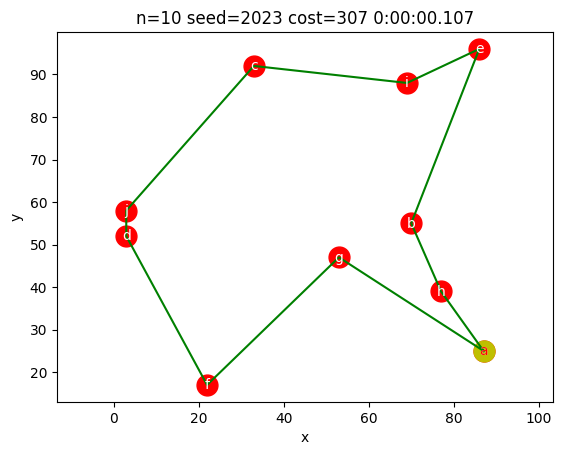

In [21]:
show_tsp(instance, ListNodesInSolution(m), True, display_seconds(t))

### How does the strength of the MTZ models differ?

As we have seen in Chapter 3, a strong MILO model is characterized by a small gap between the optimal values of its linear counterpart (the linear relaxation) and of the true (mixed integer) optimal solution.

In [22]:
tsp_dimensions = list(range(5, 101, 5))

In [23]:
MTZ_bounds = pd.DataFrame(
    index=tsp_dimensions, columns=[f.__name__ for f in mtz_models]
)
for n in tqdm(MTZ_bounds.index):
    instance = generate_tsp(n)
    for f in mtz_models:
        m = f(PrepareMTZ(ForbidDiagonal(LAP(instance))))
        linear_relaxation.apply_to(m)
        r = SOLVER.solve(m, tee=False)
        assert pyo.check_optimal_termination(r)
        MTZ_bounds.at[n, f.__name__] = m.Cost()
MTZ_bounds.style.format(precision=3)

  0%|          | 0/20 [00:00<?, ?it/s]

,OriginalMTZ,ImprovedMTZ,BestMTZ
5,255.400,257.000,265.000
10,271.300,271.333,286.000
15,232.267,233.143,314.000
20,291.300,291.579,349.000
25,311.080,311.167,347.000
30,312.867,313.034,388.000
35,380.314,380.471,468.000
40,406.125,406.231,487.000
45,453.022,453.091,526.000
50,473.340,473.388,545.500


We can see above the optimal values of the linear relaxations of the three different MTZ models for (on each line) the same instance.

Note that the instance of 10 nodes that we solved before is the same as in the table above (due to seeding the generator).

The increase of the third version is quite impressive!
How is that affecting the times required to solve the integer versions?

Small spoiler about the remainder of this notebook: it is not wise to try to solve instances of more than 15 nodes with these models!

In [24]:
MTZ_times = pd.DataFrame(
    index=tsp_dimensions[:3], columns=[f.__name__ for f in mtz_models] + ["cost"]
)
for n in tqdm(MTZ_times.index):
    cost = []
    instance = generate_tsp(n)
    for f in mtz_models:
        m = f(PrepareMTZ(ForbidDiagonal(LAP(instance))))
        t = pc()
        r = SOLVER.solve(m, tee=False)
        MTZ_times.at[n, f.__name__] = display_seconds(pc() - t)
        cost.append(np.round(m.Cost()))
    assert len(set(cost)) == 1
    MTZ_times.at[n, "cost"] = int(round(min(cost)))
MTZ_times

  0%|          | 0/3 [00:00<?, ?it/s]

,OriginalMTZ,ImprovedMTZ,BestMTZ,cost
5,0:00:00.011,0:00:00.004,0:00:00.003,269
10,0:00:00.061,0:00:00.058,0:00:00.115,307
15,0:00:00.431,0:00:00.427,0:00:00.587,335


Note that the times above are likely to be very different if you run this notebook on your own machine, even if using the same solver and version.
In particular, if your machine has more than two (virtual) processors the differences between the models will be much smaller.
In fact, it may happen that the times taken to optimize do not directly reflect the strength of the model.

In [25]:
pd.concat([MTZ_times, MTZ_bounds], axis=1).dropna().style.format(precision=3)

,OriginalMTZ,ImprovedMTZ,BestMTZ,cost,OriginalMTZ,ImprovedMTZ,BestMTZ
5,0:00:00.011,0:00:00.004,0:00:00.003,269,255.400,257.000,265.000
10,0:00:00.061,0:00:00.058,0:00:00.115,307,271.300,271.333,286.000
15,0:00:00.431,0:00:00.427,0:00:00.587,335,232.267,233.143,314.000


## Exploring the models

While often in our book we follow simple steps (model, implement, feed data, solve) it is wise to consider some improvement iterations that _improve_ the model.

We will see how to combine MTZ and DFJ, how that insight leads to actually becoming able to solve DFJ without the need for MTZ and how DFJ can be specialized to the case of symmetric costs, and the benefits of doing so (if that is indeed the case for the instances at hand).

### A tale of two models

The DFJ model is hard to use directly, since we would need to explicitly declare $2^n-2$ constraints, and that soon becomes impractical and soon after that, even impossible.

Our first attempt to grasp its use follows the idea in [this educational paper](https://epubs.siam.org/doi/pdf/10.1137/S00361445023685) in combining DFJ and MTZ.

The main idea is as follows:
 * Start by solving the linear assignment model.
 * For each sub-tour in the solution identify the set $S$ and add the corresponding DFJ sub-tour elimination constraint.
 * Solve again and repeat a pre-specified number of (`nof`) times.

At the end of the procedure above we end up with the DFJ model confined to some sub-tour elimination constraints.
These are redundant for the (mixed integer) MTZ model, but not for its linear relaxation.
We add the MTZ variables and constraints and solve the resulting mixed model.

In [26]:
def AddSomeDFJConstraints(
    instance: dict, nof: int, solver: any
) -> tuple:  # need to define a type for a solver
    """
    Add the violated DFJ constraints to the model during up to nof repeated solves.

    Args:
        instance: The TSP instance.
        nof: The maximum number of solves to add DFJ constraints.
        solver: The pyomo.Solver object to solve the model.

    Returns:
        A tuple containing the modified model and the index where an optimal solution was found.

    """
    optimal_at = None
    m = ForbidDiagonal(LAP(instance))
    m.cuts = pyo.ConstraintList()
    for i in range(nof):
        solver.solve(m)
        cycles = GetArcsInSolutionPartitionedInCycles(m)
        if len(cycles) == 1:
            optimal_at = i
            break
        for cycle in cycles:
            m.cuts.add(pyo.quicksum(m.x[i, j] for (i, j) in cycle) <= len(cycle) - 1)
    return m, optimal_at

In [27]:
nof = list(range(1, 6))
combined_results = pd.DataFrame(
    index=tsp_dimensions[:5],
    columns=list(it.chain(*[(f"tDFJ.{k}", f"tMTZ.{k}", f"LR.{k}") for k in nof]))
    + ["cost"],
)
for n in tqdm(combined_results.index):
    cost = []
    instance = generate_tsp(n)
    for k in nof:
        t = pc()
        m, optimal_at = AddSomeDFJConstraints(instance, k, SOLVER)
        combined_results.at[n, f"tDFJ.{k}"] = round(pc() - t, 2)
        if optimal_at is None:
            t = pc()
            m = BestMTZ(PrepareMTZ(m))
            r = SOLVER.solve(m, tee=False)
            combined_results.at[n, f"tMTZ.{k}"] = round(pc() - t, 2)
        cost.append(int(round(m.Cost())))
        linear_relaxation.apply_to(m)
        r = SOLVER.solve(m, tee=False)
        combined_results.at[n, f"LR.{k}"] = m.Cost()
    assert len(set(cost)) == 1, cost
    combined_results.at[n, "cost"] = min(cost)
combined_results.style.format(precision=3)

  0%|          | 0/5 [00:00<?, ?it/s]

,tDFJ.1,tMTZ.1,LR.1,tDFJ.2,tMTZ.2,LR.2,tDFJ.3,tMTZ.3,LR.3,tDFJ.4,tMTZ.4,LR.4,tDFJ.5,tMTZ.5,LR.5,cost
5,0.010,0.000,265.000,0.010,0.000,269.000,0.010,nan,269.000,0.010,nan,269.000,0.010,nan,269.000,269
10,0.010,0.020,292.000,0.010,0.010,292.000,0.010,0.020,292.000,0.020,nan,292.000,0.020,nan,292.000,307
15,0.010,0.020,335.000,0.010,0.020,335.000,0.010,nan,335.000,0.010,nan,335.000,0.080,nan,335.000,335
20,0.010,0.950,357.000,0.020,0.900,357.000,0.040,1.100,357.000,0.060,0.660,357.000,0.100,0.780,357.000,380
25,0.020,0.690,355.000,0.030,0.770,355.000,0.120,0.710,355.000,0.140,0.700,355.000,0.180,0.440,355.000,395


In [28]:
pd.concat([combined_results, MTZ_times, MTZ_bounds], axis=1).dropna(
    subset=["cost"]
).style.format(precision=3)

,tDFJ.1,tMTZ.1,LR.1,tDFJ.2,tMTZ.2,LR.2,tDFJ.3,tMTZ.3,LR.3,tDFJ.4,tMTZ.4,LR.4,tDFJ.5,tMTZ.5,LR.5,cost,OriginalMTZ,ImprovedMTZ,BestMTZ,cost,OriginalMTZ,ImprovedMTZ,BestMTZ
5,0.010,0.000,265.000,0.010,0.000,269.000,0.010,nan,269.000,0.010,nan,269.000,0.010,nan,269.000,269,0:00:00.011,0:00:00.004,0:00:00.003,269,255.400,257.000,265.000
10,0.010,0.020,292.000,0.010,0.010,292.000,0.010,0.020,292.000,0.020,nan,292.000,0.020,nan,292.000,307,0:00:00.061,0:00:00.058,0:00:00.115,307,271.300,271.333,286.000
15,0.010,0.020,335.000,0.010,0.020,335.000,0.010,nan,335.000,0.010,nan,335.000,0.080,nan,335.000,335,0:00:00.431,0:00:00.427,0:00:00.587,335,232.267,233.143,314.000


### Wait, we _can_ solve DFJ after all!

We just saw that we can implement a tiny bit of DFJ on a need basis and complement it with MTZ in order solve the combined model faster than MTZ alone.

But the process of discovering that part of DFJ that matters for the instance at hand may actually lead to solving it without the need of MTZ, and hence _only_ using (the right part of) DFJ.

What we do is known in the literature as constraint (or cut) generation, sometimes also known as _lazy constraints_.

The fundamental ingredient is known as the _separation problem_.
This is the ability to discover the important (but still missing) constraints that are in fact violated by the (infeasible) solution at hand.
Once these constraints are added, the previous solution becomes *separated* from  the new feasible set and will not be found again, ensuring termination of this iterative procedure.


In [29]:
def SolveWithDFJ(
    instance: dict,
    solver: any,  # need to define a type for a solver
    get_cost_matrix: callable = get_rounded_euclidean_distances,
) -> tuple:
    """
    Add the violated DFJ constraints to the model until the optimal solution is found.

    Args:
        instance: The TSP instance.
        solver: The pyomo.Solver object to solve the model.
        get_cost_matrix: Function to generate the cost matrix (default get_rounded_euclidean_distances).

    Returns:
        The optimal solution.

    """
    optimal_at = None
    m = ForbidDiagonal(LAP(instance, get_cost_matrix))
    m.cuts = pyo.ConstraintList()
    while True:
        solver.solve(m)
        cycles = GetArcsInSolutionPartitionedInCycles(m)
        print(round(m.Cost(), 1), [len(S) for S in cycles])
        if len(cycles) == 1:
            break
        for cycle in cycles:
            m.cuts.add(pyo.quicksum(m.x[i, j] for (i, j) in cycle) <= len(cycle) - 1)
    return ListNodesInSolution(m)

471.0 [2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2]
549.0 [27, 7, 3, 3, 2, 2, 3, 3]
562.0 [4, 9, 7, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 2]
571.0 [4, 15, 6, 3, 19, 3]
577.0 [36, 10, 4]
577.0 [36, 4, 4, 6]
578.0 [3, 16, 25, 6]
579.0 [3, 16, 25, 6]
580.0 [28, 6, 10, 4, 2]
581.0 [36, 4, 4, 6]
582.0 [44, 2, 2, 2]
583.0 [50]


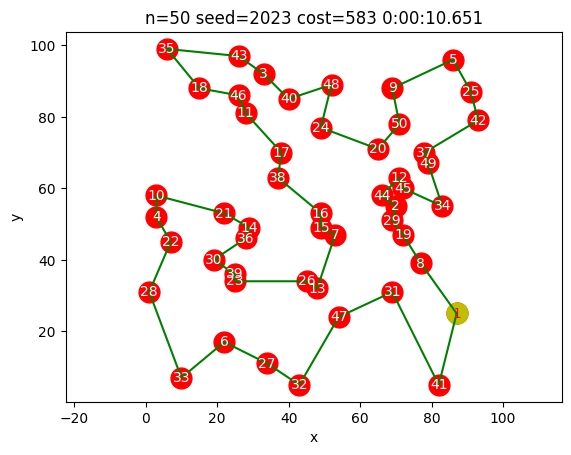

In [30]:
instance = generate_tsp(50)
t = pc()
sol = SolveWithDFJ(instance, SOLVER)
show_tsp(instance, sol=sol, node_labels=True, how=display_seconds(pc() - t))

We could not solve this instance with the (free, community edition of the) commercial solver, but the free solver did it in less than one minute!

We could be very happy about this, but now we realize that for all instances that we have been solving $c_{ij} = c_{ji}$ and in fact we do not need to have both $x_{ij}$ and $x_{ji}$.

In essence, our underlying graph has been asymmetric (hence, with directed arcs) but can be regarded as symmetric (with undirected edges).

We do need to be careful about what that means for the model!

### Symmetry

So far, our models include variables $x_{ij}$ for all $i,j \in N$.
However, if the cost matrix happens to be symmetric (and that is the case is symmetric of all instances studied in this notebook) we may ignore the direction, i.e. consider only one of the two arcs $(i,j)$ or $(j,i)$.

The number of edges $(i,j)$ for $i < j$ is less than half of the number of arcs.

The symmetric model can be easily derived from the DFJ model: the linear assignment structure is replaced by constraining each node to have degree 2.

Note that no variant of MTZ is known for the symmetric case!

In [31]:
instance = generate_tsp(50)

552.0 [28, 7, 3, 3, 3, 3, 3]
571.0 [4, 15, 6, 3, 19, 3]
577.0 [36, 4, 4, 6]
581.0 [3, 16, 11, 20]
583.0 [50]


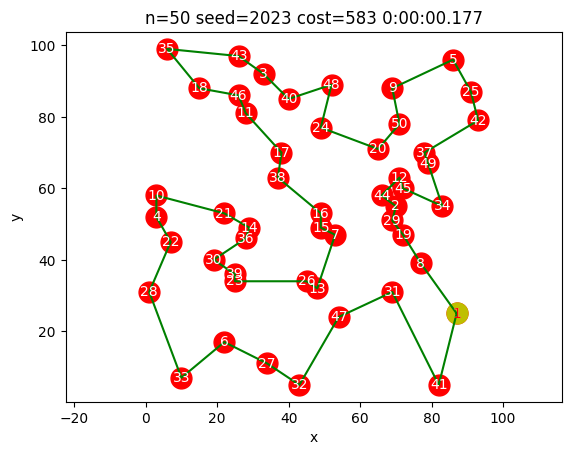

In [32]:
def SymmetricBasicModel(instance: dict) -> pyo.ConcreteModel:
    """
    Create a symmetric basic model for the TSP.

    Args:
        instance: The TSP instance.

    Returns:
        The created pyomo.ConcreteModel.

    """
    I, R = get_indices_and_reverse_lookup(instance)
    C = get_rounded_euclidean_distances(instance)
    m = pyo.ConcreteModel("STSP")
    m.n = pyo.Param(initialize=len(I))
    m.I = pyo.Set(initialize=I)
    m.E = pyo.Set(initialize=it.combinations(I, 2))
    m.x = pyo.Var(m.E, domain=pyo.Binary)
    m.C = pyo.Param(m.E, initialize=lambda m, i, j: C[R[i], R[j]])

    @m.Objective(sense=pyo.minimize)
    def Cost(m):
        return pyo.quicksum(m.C[e] * m.x[e] for e in m.E)

    @m.Constraint(m.I)
    def enter_and_leave(m, i):
        return pyo.quicksum(m.x[e] for e in m.E if i in set(e)) == 2

    return m


def GetSelected(m) -> list:
    """
    Get the selected edges in the model.

    Args:
        m: The pyomo.ConcreteModel.

    Returns:
        A list of selected edges.

    """
    return [e for e in m.E if m.x[e]() > 0.5]


def GetAdjacent(selected, I) -> dict:
    """
    Get the adjacent nodes for each node in the selected edges.

    Args:
        selected: The selected edges.
        I: The set of all nodes.

    Returns:
        A dictionary mapping each node to its adjacent nodes.

    """
    adjacent = {i: [] for i in I}
    for i, j in selected:
        adjacent[i].append(j)
        adjacent[j].append(i)
    return adjacent


def GetSubTours(adjacent) -> list:
    """
    Get the sub-tours from the adjacent nodes.

    Args:
        adjacent: The dictionary mapping each node to its adjacent nodes.

    Returns:
        A list of sub-tours.

    """
    all_nodes = set(list(adjacent.keys()))
    sub_tours = []
    while len(all_nodes) > 0:
        node = next(iter(all_nodes))
        tour = [node]
        all_nodes.remove(node)
        while not all(j in tour for j in adjacent[tour[-1]]):
            for j in adjacent[tour[-1]]:
                if j not in tour:
                    tour.append(j)
                    all_nodes.remove(j)
                    break
        sub_tours.append(tour)
    return sub_tours


t = pc()

m = SymmetricBasicModel(instance)
m.ellim = pyo.ConstraintList()

while True:
    SOLVER.solve(m)
    sub_tours = GetSubTours(GetAdjacent(GetSelected(m), m.I))
    print(round(m.Cost(), 1), [len(S) for S in sub_tours])
    if len(sub_tours[0]) == m.n:
        break
    for S in sub_tours:
        m.ellim.add(
            pyo.quicksum(m.x[e] for e in m.E if all(i in S for i in e)) <= len(S) - 1
        )

assert len(sub_tours) == 1 and len(sub_tours[0]) == len(instance["NODE_COORD_SECTION"])
sol = sub_tours[0]
sol.append(sol[0])

show_tsp(instance, sol=sub_tours[0], node_labels=True, how=display_seconds(pc() - t))

Are you amazed about the speedup (same solver)?

You *should* be!

## Revisiting the implementation: lazy constraint generation!

Adding constraints on a need basis required so far that we repeatedly solved the problem from scratch, each time with a slightly larger model than before.
In fact, some solvers allow the constraints to be added _while_ solving.
And `pyomo` offers ways to use that ability!

### Callbacks

So far, we extended our model by adding the needed constraints and the solved again.

Some solvers support a more sophisticated way to add constraints while solving.
The mechanism to do so is called a _callback_: a function that we define and offer to the solver to call while solving the problem.

The solver can do this at different moments.
For us, the moment of interest is when the solver finds a feasible solution: we can check if it satisfies all the not yet defined constraints, and if needed add some new constraints.

`Pyomo` supports callbacks for using with `gurobi`, `cplex` and `express`.
These are all commercial solvers, of which the free (community edition) of gurobi is the most generous, allowing for up to 2000 variables and/or constraints.


In [33]:
import gurobipy as gp
from gurobipy import GRB

In [34]:
def my_callback(cb_m, cb_opt, cb_where):
    """
    Custom callback function for the optimization solver.

    Args:
        cb_m: The pyomo.ConcreteModel.
        cb_opt: The optimization solver.
        cb_where: The callback location.

    """
    if cb_where == GRB.Callback.MIPSOL:
        cb_opt.cbGetSolution(vars=[cb_m.x[e] for e in cb_m.E])
        sub_tours = GetSubTours(GetAdjacent(GetSelected(cb_m), cb_m.I))
        if len(sub_tours) > 1:
            for S in sub_tours:
                cb_opt.cbLazy(
                    cb_m.ellim.add(
                        pyo.quicksum(
                            cb_m.x[e] for e in cb_m.E if all(i in S for i in e)
                        )
                        <= len(S) - 1
                    )
                )

In [35]:
t = pc()

m = SymmetricBasicModel(instance)
m.ellim = pyo.ConstraintList()
PERSISTENT_SOLVER.set_instance(m)
PERSISTENT_SOLVER.set_gurobi_param("OutputFlag", 0)
PERSISTENT_SOLVER.set_gurobi_param("PreCrush", 1)
PERSISTENT_SOLVER.set_gurobi_param("LazyConstraints", 1)
PERSISTENT_SOLVER.set_callback(my_callback)
r = PERSISTENT_SOLVER.solve()

t = pc() - t

In [36]:
sub_tours = GetSubTours(GetAdjacent(GetSelected(m), m.I))
assert len(sub_tours) == 1 and len(sub_tours[0]) == len(instance["NODE_COORD_SECTION"])

In [37]:
sol = sub_tours[0]
sol.append(sol[0])

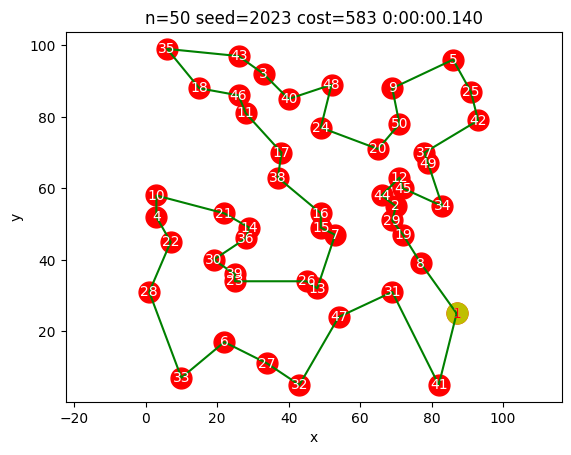

In [38]:
show_tsp(instance, sol=sol, node_labels=True, how=display_seconds(t))

There is an additional benefit here! While the commercial solver would not solve this instance in  the previous implementation with repeated solves (since the instance soon includes a number of constraints beyond the free tier) it does now, since the additional constraints added _while solving_ don't count!

### Gray area

Defining a callback forces us to adhere to solver specific knowledge.

One may argue that the flexibility offered by `pyomo` is now somewhat lost.

Maybe this is the moment to consider modeling the whole model in the solver's dialect (`gurobipy` in this case) and bypass the overhead of `pyomo` all together.

In [39]:
def SymmetricTSPViaGurobi(C, trace):
    """
    Solve the symmetric traveling Salesman problem using Gurobi.

    Args:
        C: Cost matrix (symmetric).
        trace: Flag to enable/disable output traces.

    Returns:
        tour: List of nodes representing the optimal tour.

    """
    assert np.allclose(C, C.T, rtol=1e-05, atol=1e-08), "cost should be symmetric"

    m = gp.Model()

    m._n = len(C)
    m._I = range(m._n)
    m._E = list(it.combinations(m._I, 2))

    m._x = m.addVars(
        m._E, obj={(i, j): C[i, j] for (i, j) in m._E}, vtype=GRB.BINARY, name="x"
    )
    m.addConstrs(m._x.sum(i, "*") + m._x.sum("*", i) == 2 for i in m._I)

    def GetSelected(x):
        return [(i, j) for (i, j), v in x.items() if v > 0.5]

    def subtourelim(model, where):
        if where == GRB.Callback.MIPSOL:
            sub_tours = GetSubTours(
                GetAdjacent(GetSelected(model.cbGetSolution(model._x)), model._I)
            )
            for tour in sub_tours:
                if len(tour) < model._n:
                    model.cbLazy(
                        gp.quicksum(
                            model._x[i, j] for i, j in it.combinations(sorted(tour), 2)
                        )
                        <= len(tour) - 1
                    )

    m.Params.OutputFlag = trace
    m.Params.LazyConstraints = 1
    m.optimize(subtourelim)

    sub_tours = GetSubTours(GetAdjacent(GetSelected(m.getAttr("X", m._x)), m._I))
    assert len(sub_tours) == 1, sub_tours
    tour = sub_tours[0]
    assert len(tour) == m._n, tour
    tour.append(tour[0])

    m.printStats()

    return tour

In [40]:
def GurobiSymmetric(instance, trace):
    """
    Solve the symmetric traveling salesman problem using Gurobi.

    Args:
        instance: TSP instance.
        trace: Flag to enable/disable output traces.

    Returns:
        tour: List of nodes representing the optimal tour.

    """
    C = get_rounded_euclidean_distances(instance)

    tour = SymmetricTSPViaGurobi(C, trace)

    I, _ = get_indices_and_reverse_lookup(instance)
    return [I[i] for i in tour]

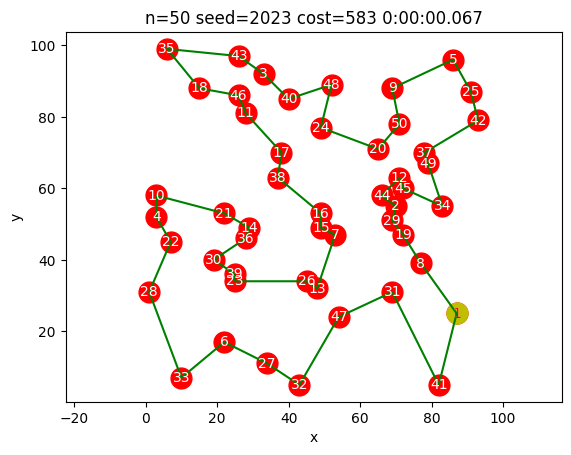

In [41]:
t = pc()
sol = GurobiSymmetric(instance, False)
t = pc() - t
show_tsp(instance, sol=sol, node_labels=True, how=display_seconds(t))

Since the number of variables is $n(n-1)/2$ dominates the number of explicit constraints $n$, the highest $n$ that fits the community edition is $n=63$ yielding $1953$ variables and $63$ constraints.

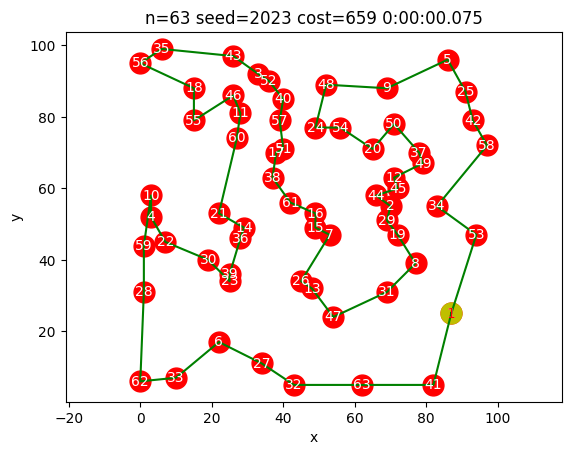

In [42]:
instance = generate_tsp(63)
t = pc()
sol = GurobiSymmetric(instance, False)
t = pc() - t
show_tsp(instance, sol=sol, node_labels=True, how=display_seconds(t))

Very fast, right? Maybe we can try some of the benchmarks now!

## Famous benchmark instances from the Internet

In [43]:
url_tsp_world = "https://www.math.uwaterloo.ca/tsp/world/"

In [44]:
def url_exists(url):
    """
    Check if the given URL exists by sending a GET request and checking the status code.

    Args:
        url: URL to check.

    Returns:
        True if the URL exists (status code 200), False otherwise.
    """
    return requests.get(url).status_code == 200


def ReadTextFromURL(url):
    """
    Read text data from a given URL.

    Args:
        url: URL to fetch the text data from.

    Returns:
        The text data fetched from the URL.
    """
    return requests.get(url).text


def NumberOrString(text):
    """
    Convert the given text to an integer, float, or string.

    Args:
        text: Text to convert.

    Returns:
        Converted value as an integer, float, or string.
    """
    if text.isdigit():
        return int(text)
    elif text.replace(".", "", 1).isdigit():
        return float(text)
    else:
        return text


def LeftPart(lineWithColon):
    """
    Extract the left part of a string before the colon.

    Args:
        lineWithColon: Input string containing a colon.

    Returns:
        Left part of the string before the colon.
    """
    return lineWithColon.split(":")[0].strip()


def RightPart(lineWithColon):
    """
    Extract the right part of a string after the colon.

    Args:
        lineWithColon: Input string containing a colon.

    Returns:
        Right part of the string after the colon.
    """
    return NumberOrString(lineWithColon.split(":", 1)[1].strip())


def ParseComment(comment):
    """
    Parse the comment string and convert it to a dictionary.

    Args:
        comment: Comment string to parse.

    Returns:
        Dictionary containing parsed comment information.
    """
    asList = comment.replace("(", "").replace(")", "").split(",")
    result = {LeftPart(line): RightPart(line) for line in asList if ":" in line}
    result["COMMENT"] = ",".join([line for line in asList if ":" not in line])
    return result


def Dispatch(name, *args, **kwargs):
    """
    Dispatch the given name to the appropriate function based on a dispatcher dictionary.

    Args:
        name: Name to dispatch.
        *args: Additional positional arguments.
        **kwargs: Additional keyword arguments.

    Returns:
        Result of the dispatched function based on the name.
    """
    dispatcher = {"DIMENSION": int, "CAPACITY": int, "COMMENT": ParseComment}
    if name in dispatcher:
        return dispatcher[name](*args, **kwargs)
    else:
        return NumberOrString(*args, **kwargs)


def ReadCVRP(text):
    """
    Read the Capacitated Vehicle Routing Problem (CVRP) instance from the given text.

    Args:
        text: Text data containing the CVRP instance.

    Returns:
        Dictionary representing the CVRP instance.
    """
    lines = [line for line in text.split("\n") if len(line) > 0]
    if "EOF" not in lines[-1]:
        lines.append("EOF")
    instance = {
        LeftPart(line): Dispatch(LeftPart(line), RightPart(line))
        for line in lines
        if ":" in line
    }
    idxSections = [
        i for i, line in enumerate(lines) if "SECTION" in line or "EOF" in line
    ]
    for i, idx in enumerate(idxSections[:-1]):
        key = lines[idx].strip()
        instance[key] = [
            [NumberOrString(x) for x in line.split()]
            for line in lines[idx + 1 : idxSections[i + 1]]
        ]
    return instance


def GetNationalTSP(filename, world=url_tsp_world):
    """
    Fetch the National TSP instance from the given filename.

    Args:
        filename: Filename of the National TSP instance.

    Returns:
        Dictionary representing the National TSP instance.
    """
    return ReadCVRP(ReadTextFromURL(world + filename))

In [45]:
def ReadWorldSummary(world=url_tsp_world):
    """
    Read the world summary table from the given URL and return it as a pandas DataFrame.

    Args:
        world: URL of the world summary page. Defaults to url_tsp_world.

    Returns:
        Pandas DataFrame containing the world summary table.
    """
    if url_exists(world):
        result = pd.read_html(
            f"{world}summary.html",
            header=0,
            converters={"Tour": lambda x: int(str(x).replace(".", ""))},
        )[-1]
        result["size"] = result["Name"].str.extract("(\d+)").astype(int)
        result.sort_values("size", inplace=True, ignore_index=True)
        return result

In [46]:
tsp_world_summary = ReadWorldSummary(world=url_tsp_world)
tsp_world_summary

,Name,Gap,Bound,Tour,Source of Tour,size
0,wi29,Optimal,27603,27603,Concorde,29
1,dj38,Optimal,6656,6656,Concorde,38
2,qa194,Optimal,9352,9352,Concorde,194
3,uy734,Optimal,79114,79114,Concorde,734
4,zi929,Optimal,95345,95345,Concorde,929
5,lu980,Optimal,11340,11340,Concorde,980
6,rw1621,Optimal,26051,26051,Concorde,1621
7,mu1979,Optimal,86891,86891,Concorde,1979
8,nu3496,Optimal,96132,96132,Concorde,3496
9,ca4663,Optimal,1290319,1290319,Concorde,4663


Well, these sizes soon become too large for us!
Definitely for the community edition of `gurobi` (we can go up to the first two).
Actually, this technique becomes impractical soon after that, even when having a `gurobi` license in place.
No mather how good the model is, the problem is still very hard!
The solutions listed above where found by highly researched solvers, specific for the TSP.

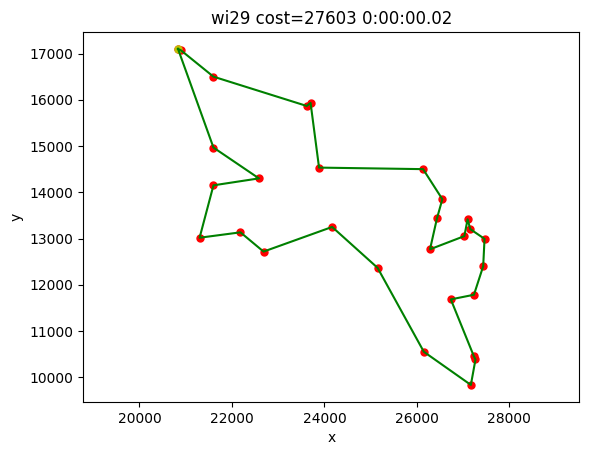

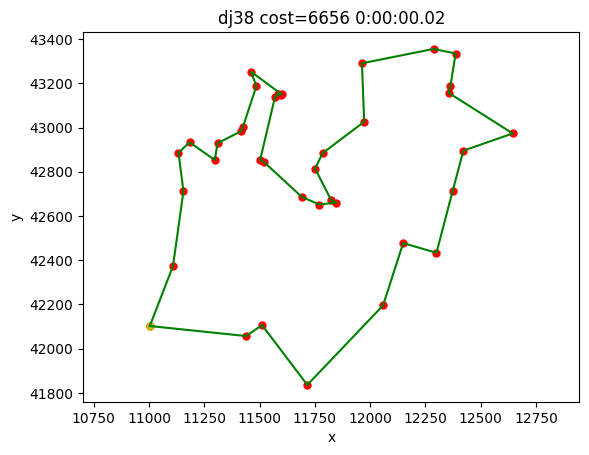

In [47]:
for name in tsp_world_summary.Name[:2]:
    instance = GetNationalTSP(f"{name}.tsp")
    t = pc()
    sol = GurobiSymmetric(instance, False)
    show_tsp(
        instance, sol=sol, node_labels=False, how=str(timedelta(seconds=pc() - t))[:-4]
    )

## Beyond this?

Maybe there are some things that you may need to address related to TSP that are not covered here.

### Variants

Simple variants of the problem, such as not needing to return to the start node (shortest Hamiltonian path or open TSP) of using a given number of routes instead of one (the multiple TSP), are already with your reach.

These variants can be solved by _transformations_ of the instance, or by remodeling.

We will illustrate the transformation approach, and leave the remodeling to you as exercises.

#### Open TSP
Suppose (without loss of generality) that you start at node $0$ and should visit all other nodes, without the need to return to $0$.

Then, it is enough to modify your cost matrix $C$ by making all costs $c_{i0} = 0$ and solve the corresponding TSP.

*Note that this modified TSP is asymmetric regardless of the nature of the original instance!*

In [48]:
instance = generate_tsp(20)

A simple closure does the trick!
Notice that we index at _inner indices_ for code simplicity now.

In [49]:
def get_cost_matrix_open_at(instance: dict[str, any], open_at: int = 0):
    def get_modified_cost_matrix(instance):
        C = get_rounded_euclidean_distances(instance)
        C[:, open_at] = 0
        return C

    return get_modified_cost_matrix

In [50]:
get_cost_matrix_open_at_0 = get_cost_matrix_open_at(instance, 0)

In [51]:
open_sol = SolveWithDFJ(instance, SOLVER, get_cost_matrix_open_at_0)

266.0 [8, 3, 2, 2, 3, 2]
291.0 [7, 2, 3, 2, 2, 2, 2]
315.0 [5, 2, 4, 3, 3, 3]
319.0 [8, 3, 9]
320.0 [8, 12]
320.0 [6, 2, 12]
321.0 [10, 7, 3]
323.0 [20]


In [52]:
closed_sol = SolveWithDFJ(instance, SOLVER)

286.0 [2, 2, 3, 2, 2, 2, 3, 2, 2]
348.0 [3, 2, 2, 5, 3, 3, 2]
366.0 [3, 5, 3, 9]
366.0 [4, 12, 4]
366.0 [4, 12, 4]
370.0 [5, 4, 4, 3, 2, 2]
375.0 [4, 4, 8, 4]
376.0 [4, 12, 4]
378.0 [18, 2]
379.0 [16, 4]
379.0 [8, 12]
379.0 [8, 12]
380.0 [20]


In [53]:
open_sol

[1, 8, 19, 2, 12, 20, 5, 9, 17, 11, 3, 18, 10, 4, 14, 16, 15, 7, 13, 6, 1]

In [54]:
closed_sol

[1, 13, 7, 15, 16, 14, 6, 4, 10, 18, 3, 11, 17, 9, 5, 20, 12, 2, 19, 8, 1]

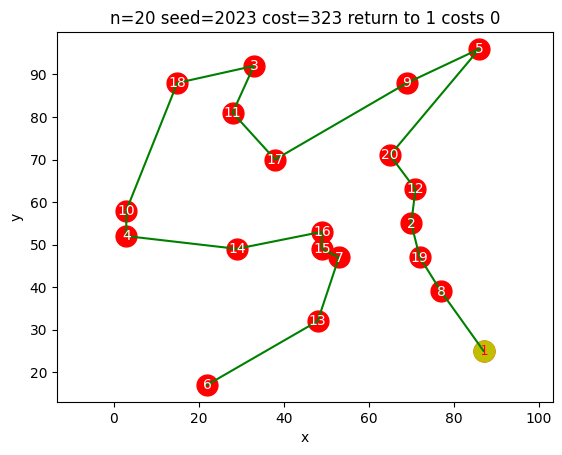

In [55]:
show_tsp(
    instance,
    open_sol[:-1],
    node_labels=True,
    get_cost_matrix=get_cost_matrix_open_at_0,
    how="return to 1 costs 0",
)

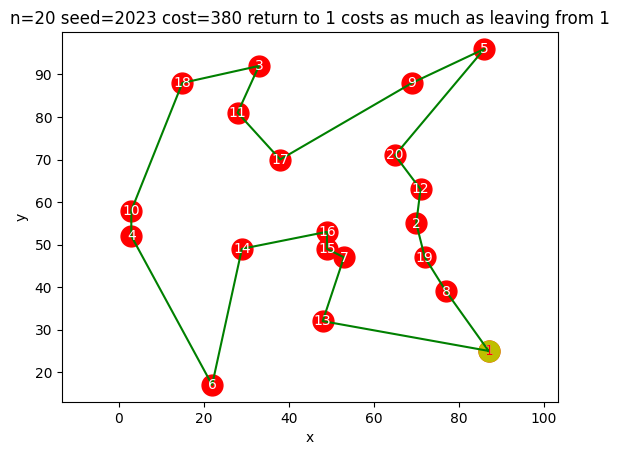

In [56]:
show_tsp(
    instance,
    closed_sol,
    node_labels=True,
    how="return to 1 costs as much as leaving from 1",
)

#### Multiple TSP

Suppose that you start at some node with $k$ sales persons that should partition the other nodes and return to the starting node.

Then, it is enough to replicate that node into $k$ replicas, with a prohibitively large cost between all pairs of replicas (to force the sales person to go on a route).

*Note that this modified TSP stays symmetric if instance given was symmetric!*

Obviously that you can also combine these extensions!

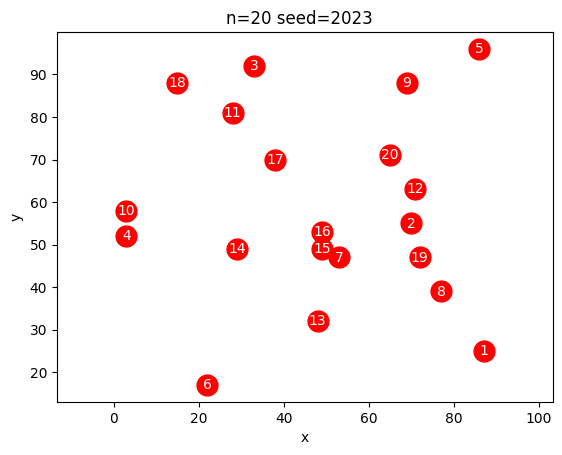

In [57]:
instance = generate_tsp(20)
show_tsp(instance, node_labels=True)

For this instance node $17$ seems to be an ideal candidate for the home base of $2$ sales persons.

In [58]:
I, R = get_indices_and_reverse_lookup(instance)

In [59]:
(_, x, y) = instance["NODE_COORD_SECTION"][R[17]]

We call the replica $0$, since that label was not yet used.

In [60]:
instance["NODE_COORD_SECTION"] = [(0, x, y)] + instance["NODE_COORD_SECTION"]

In [61]:
sol = SolveWithDFJ(instance, SOLVER)

268.0 [2, 2, 2, 3, 2, 2, 3, 3, 2]
339.0 [3, 3, 2, 2, 3, 3, 2, 3]
366.0 [13, 4, 4]
366.0 [10, 3, 5, 3]
366.0 [13, 4, 4]
368.0 [13, 5, 3]
372.0 [13, 4, 4]
374.0 [5, 4, 4, 4, 2, 2]
378.0 [19, 2]
378.0 [5, 8, 8]
378.0 [5, 8, 8]
379.0 [17, 4]
380.0 [21]


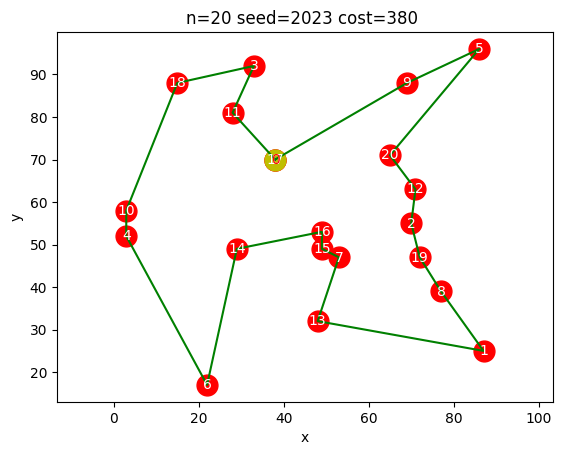

In [62]:
show_tsp(instance, sol, node_labels=True)

Allowing the salesmen to stay at home leadds to only one leaving and hence to one single route.

In [63]:
def get_cost_matrix_forbid_these(instance, these=[0, 17]):
    C = get_rounded_euclidean_distances(instance)
    I, R = get_indices_and_reverse_lookup(instance)
    idx = [R[t] for t in these]
    C[np.ix_(idx, idx)] = int(1e6)
    return C

307.0 [2, 2, 2, 2, 2, 2, 2, 3, 2, 2]
380.0 [13, 3, 2, 3]
392.0 [4, 3, 5, 9]
392.0 [10, 4, 4, 3]
392.0 [13, 4, 4]
394.0 [9, 5, 4, 3]
398.0 [2, 4, 11, 4]
398.0 [13, 4, 4]
400.0 [2, 17, 2]
401.0 [13, 8]
401.0 [13, 8]
402.0 [4, 13, 4]
402.0 [17, 4]
402.0 [19, 2]
403.0 [21]


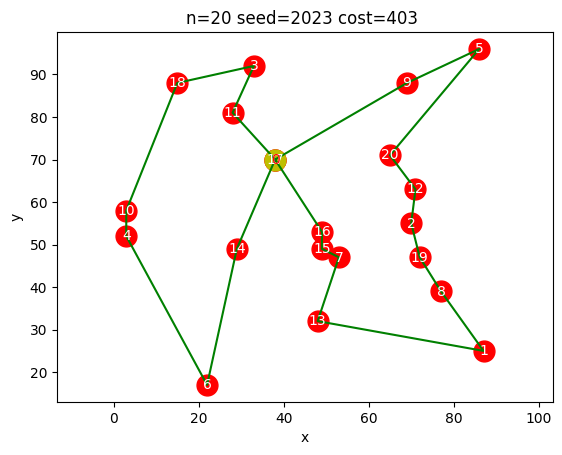

In [64]:
sol = SolveWithDFJ(instance, SOLVER, get_cost_matrix_forbid_these)
show_tsp(instance, sol, node_labels=True)

In [65]:
sol

[0, 16, 15, 7, 13, 1, 8, 19, 2, 12, 20, 5, 9, 17, 11, 3, 18, 10, 4, 6, 14, 0]

## Portability

Although we are accustomed to modeling _data driven_ and reflect the nature of the domain being solved in, for instance, the indices of the variables we are now dealing with a problem whose input is, in fact, just a square matrix of costs.

In such "pure" cases is, in fact, better to strive for portable code.

In fact, `SymmetricTSPViaGurobi` is already portable since it takes its data from `C` only.

May you wish, then you can copy and paste the code below for your own use. Please attribute! And remember that some functions are defined above, for reuse.

Note that it is trivial to express the solution in the original indices.

In [66]:
def original_solution(I: dict[any, int], sol: list[int]) -> list[any]:
    return [I[s] for s in sol]

In [67]:
def AsymmetricTSPViaGurobi(C, trace):
    """
    Solve the asymmetric traveling salesman problem using Gurobi.

    Args:
        C: Cost matrix.
        trace: Flag to enable/disable output traces.

    Returns:
        tour: List of nodes representing the optimal tour.

    """
    m = gp.Model()

    m._n = len(C)
    m._I = range(m._n)
    m._E = list(it.product(m._I, m._I))

    m._x = m.addVars(
        m._E, obj={(i, j): C[i, j] for (i, j) in m._E}, vtype=GRB.BINARY, name="x"
    )
    m.addConstrs(m._x.sum(i, "*") == 1 for i in m._I)
    m.addConstrs(m._x.sum("*", i) == 1 for i in m._I)

    def GetNodeSuccessorFromArcVariables(x):
        return {i: j for (i, j), v in x.items() if v > 0.5}

    def subtourelim(model, where):
        if where == GRB.Callback.MIPSOL:
            cycles = PartitionSuccessorIntoCycles(
                GetNodeSuccessorFromArcVariables(model.cbGetSolution(model._x))
            )
            for cycle in cycles:
                if len(cycle) < model._n:
                    model.cbLazy(
                        gp.quicksum(model._x[i, j] for (i, j) in cycle)
                        <= len(cycle) - 1
                    )

    m.Params.OutputFlag = trace
    m.Params.LazyConstraints = 1
    m.optimize(subtourelim)

    succ = GetNodeSuccessorFromArcVariables(m.getAttr("X", m._x))
    cycles = PartitionSuccessorIntoCycles(succ)
    assert len(cycles) == 1, cycles
    cycle = cycles[0]
    assert len(cycle) == m._n, cycle

    m.printStats()

    sol = [next(iter(succ.keys()))]
    while not succ[sol[-1]] in sol:
        sol.append(succ[sol[-1]])
    sol.append(sol[0])

    return sol

In [68]:
def AsymmetricTSPViaPyomo(C, solver, trace):
    """
    Solve the asymmetric traveling salesman problem using Pyomo.

    Args:
        C: Cost matrix.
        solver: The pyomo.Solver object to solve the model.
        trace: Flag to enable/disable output traces.

    Returns:
        tour: List of nodes representing the optimal tour.

    """
    n = len(C)
    I = list(range(n))

    m = pyo.ConcreteModel("ATSP")
    m.n = pyo.Param(initialize=n, mutable=False)
    m.I = pyo.Set(initialize=I)
    m.IJ = m.I * m.I
    m.c = pyo.Param(m.IJ, initialize=lambda m, i, j: C[i, j], mutable=False)
    m.x = pyo.Var(m.IJ, domain=pyo.Binary)

    @m.Objective(sense=pyo.minimize)
    def Cost(m: pyo.ConcreteModel) -> pyo.Expression:
        return pyo.quicksum(m.c[i, j] * m.x[i, j] for i, j in m.IJ)

    @m.Constraint(m.I)
    def DepartFromEach(m: pyo.ConcreteModel, i: m.I) -> pyo.Constraint:
        return pyo.quicksum(m.x[i, j] for j in m.I) == 1

    @m.Constraint(m.I)
    def ArriveAtEach(m: pyo.ConcreteModel, i: m.I) -> pyo.Constraint:
        return pyo.quicksum(m.x[j, i] for j in m.I) == 1

    @m.Constraint(m.I)
    def ForbidDiagonal(m: pyo.ConcreteModel, i: m.I) -> pyo.Constraint:
        return m.x[i, i] == 0

    m.cuts = pyo.ConstraintList()
    while True:
        solver.solve(m, tee=trace)
        cycles = GetArcsInSolutionPartitionedInCycles(m)
        if len(cycles) == 1:
            break
        for cycle in cycles:
            m.cuts.add(pyo.quicksum(m.x[i, j] for (i, j) in cycle) <= len(cycle) - 1)
    return ListNodesInSolution(m)

In [69]:
def SymmetricTSPViaPyomo(C, solver, trace):
    """
    Solve the asymmetric traveling salesman problem using Pyomo.

    Args:
        C: Cost matrix.
        solver: The pyomo.Solver object to solve the model.
        trace: Flag to enable/disable output traces.

    Returns:
        tour: List of nodes representing the optimal tour.

    """
    n = len(C)
    I = list(range(n))
    m = pyo.ConcreteModel("STSP")
    m.n = pyo.Param(initialize=n)
    m.I = pyo.Set(initialize=I)
    m.E = pyo.Set(initialize=it.combinations(I, 2))
    m.x = pyo.Var(m.E, domain=pyo.Binary)
    m.C = pyo.Param(m.E, initialize=lambda m, i, j: C[i, j])

    @m.Objective(sense=pyo.minimize)
    def Cost(m):
        return pyo.quicksum(m.C[e] * m.x[e] for e in m.E)

    @m.Constraint(m.I)
    def enter_and_leave(m, i):
        return pyo.quicksum(m.x[e] for e in m.E if i in set(e)) == 2

    m.ellim = pyo.ConstraintList()

    while True:
        solver.solve(m, tee=trace)
        sub_tours = GetSubTours(GetAdjacent(GetSelected(m), m.I))
        if len(sub_tours[0]) == m.n:
            break
        for S in sub_tours:
            m.ellim.add(
                pyo.quicksum(m.x[e] for e in m.E if all(i in S for i in e))
                <= len(S) - 1
            )

    assert len(sub_tours) == 1 and len(sub_tours[0]) == n
    sol = sub_tours[0]
    sol.append(sol[0])

    return sol

In [70]:
instance = generate_tsp(30)
C = get_rounded_euclidean_distances(instance)
I, _ = get_indices_and_reverse_lookup(instance)

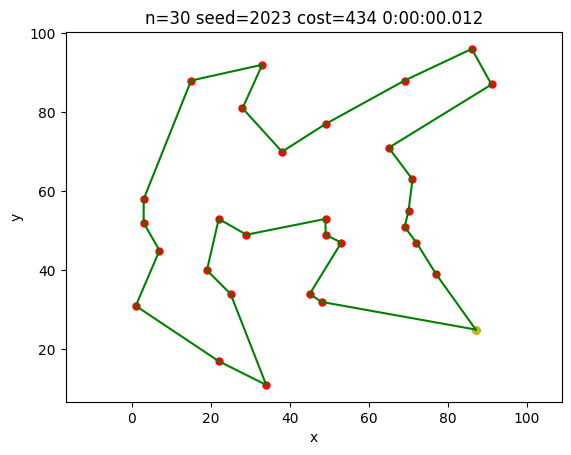

In [71]:
t = pc()
sol = SymmetricTSPViaGurobi(C, False)
show_tsp(instance, sol=original_solution(I, sol), how=display_seconds(pc() - t))

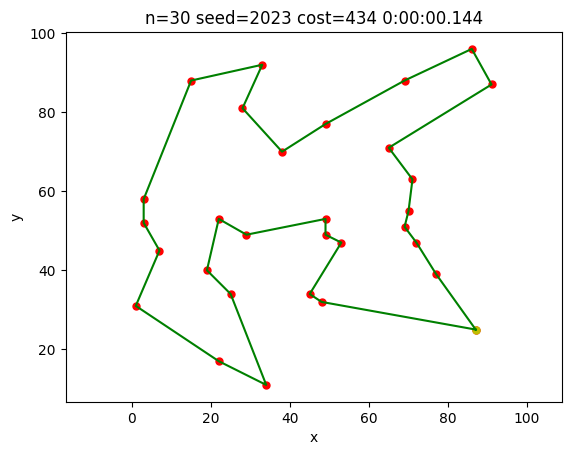

In [72]:
t = pc()
sol = AsymmetricTSPViaGurobi(C, False)
show_tsp(instance, sol=original_solution(I, sol), how=display_seconds(pc() - t))

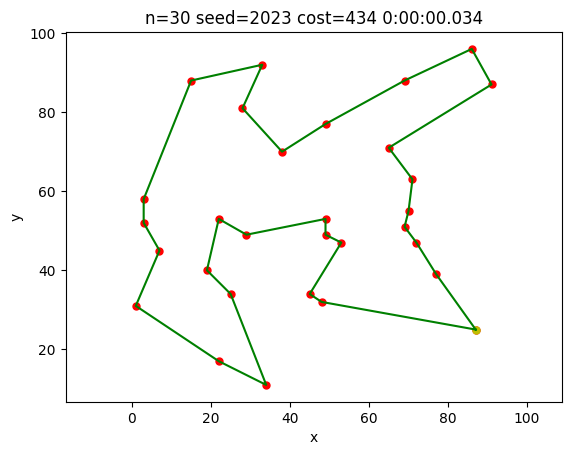

In [73]:
t = pc()
sol = SymmetricTSPViaPyomo(C, SOLVER, False)
show_tsp(instance, sol=original_solution(I, sol), how=display_seconds(pc() - t))

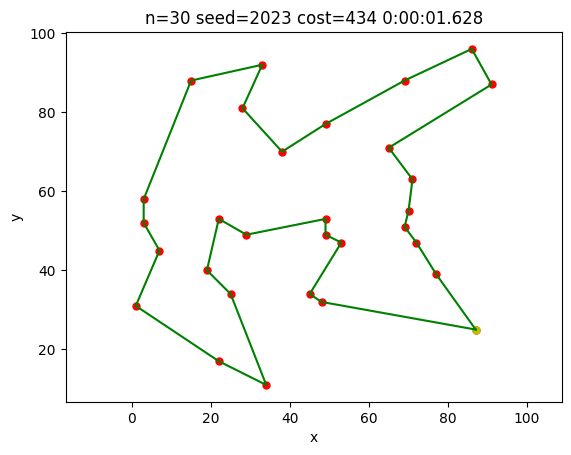

In [74]:
t = pc()
sol = AsymmetricTSPViaPyomo(C, SOLVER, False)
show_tsp(instance, sol=original_solution(I, sol), how=display_seconds(pc() - t))

Note that if your instance is symmetric, solving the asymmetric model is much more expensive.

## Larger models?

Maybe read [the book](https://www.math.uwaterloo.ca/tsp/book/index.html) and write your own TSP solver or just run [concorde](https://github.com/jvkersch/pyconcorde).